# Mohammad Mahdi Razmjoo
## 400101272

In [2]:
!pip install lime shap eli5 scikit-image --quiet

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries
import eli5
from eli5.sklearn import PermutationImportance

---

##  Data Loading and Cleaning

In [ ]:
def load_and_clean(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop_duplicates()
    df = df.drop(columns=[col for col in ['ID', 'Name'] if col in df.columns])
    df = df.dropna(thresh=int(df.shape[1] * 0.8))
    return df

df = pd.read_csv('fifa19.csv').pipe(load_and_clean)
print(f"Data shape after cleaning: {df.shape}")

Data shape after cleaning: (16122, 87)


### Why this part is done:

1. The function drops duplicate rows to ensure that repeated entries do not bias the analysis or machine learning model. This improves data quality by keeping only unique records.

2. It drops columns like 'ID' and 'Name' if they exist, because these are typically identifiers that don't carry predictive power. Removing them reduces noise in the dataset.

3. Rows that have more than 20% missing values are removed. These rows are likely incomplete and may negatively impact model performance or analysis. The threshold ensures we keep rows that are mostly complete.

4. The use of `.pipe()` allows chaining the data cleaning process in a clean and functional style. It improves readability and modularity of the code.

5. Finally, printing the shape of the cleaned DataFrame gives insight into how much data was removed and how much remains. This helps evaluate whether the cleaning process is reasonable or too aggressive.

### What is gained or understood:

- A cleaner dataset with reduced redundancy and irrelevant information.
- Better integrity and usability of data for analysis or modeling.
- Confidence in the quality and structure of the dataset before moving to the next steps.
- A modular and scalable pipeline for reusing or extending data cleaning in the future.


---

##  Preprocessing Pipeline


In [ ]:
df['label'] = (df['Overall'] > 75).astype(int)

X = df.drop(columns=['Overall', 'label'])
y = df['label']

type_map = X.dtypes
numeric_features = type_map[type_map.isin(['int64','float64'])].index.tolist()
categorical_features = type_map[type_map == 'object'].index.tolist()

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features)
])

### Why this part is done:

- A new binary label column `label` is created to simplify the problem and simulate a binary classification task. Players with an 'Overall' rating above 75 are labeled as good (1), and the rest as bad (0). This helps highlight issues like class imbalance and simplifies evaluation metrics.

- `X` and `y` are separated into features and labels, which is a standard step before modeling. The 'Overall' column is also dropped from features to prevent data leakage, as it directly influences the target.

- The code identifies numeric and categorical features automatically based on their data types. This distinction is necessary because different preprocessing techniques are suitable for different types of data.

- A preprocessing pipeline for numeric features is defined:
  - `SimpleImputer` with `median` strategy handles missing values robustly, especially when data is skewed.
  - `StandardScaler` standardizes the numeric data to have zero mean and unit variance, which benefits many machine learning algorithms.

- A pipeline for categorical features is also defined:
  - `SimpleImputer` fills in missing values with the most frequent category, which is a safe default.
  - `OneHotEncoder` converts categorical variables into a format usable by most models, creating binary columns for each category while ignoring unknown values during inference.

- Finally, `ColumnTransformer` combines both numeric and categorical pipelines so they can be applied in parallel. This creates a unified preprocessing pipeline that can be used consistently across training and test data.

### What is gained or understood:

- The dataset is transformed into a machine learning–ready format, handling missing values and scaling appropriately.
- The distinction between numeric and categorical data is respected, allowing for tailored preprocessing steps.
- Pipelines increase modularity, reusability, and clarity of the preprocessing workflow.
- Creating a binary label enables binary classification tasks and sets the stage for evaluating class imbalance or model fairness.
- Using `ColumnTransformer` ensures that all transformations can be applied consistently in future modeling steps, such as cross-validation or test set evaluation.


---

##  Baseline Classifier

In [ ]:
clf = Pipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42, test_size=0.2
)

baseline_scores = cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy')
print("Baseline CV Accuracy:", np.mean(baseline_scores))

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

Baseline CV Accuracy: 0.9850352795223696
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2942
           1       0.96      0.92      0.94       283

    accuracy                           0.99      3225
   macro avg       0.97      0.96      0.97      3225
weighted avg       0.99      0.99      0.99      3225



### Why this part is done:

- A machine learning pipeline is built using `Pipeline`, combining the preprocessing steps (`preprocessor`) with a `RandomForestClassifier`. This ensures that the same preprocessing is applied consistently during both training and prediction, reducing the risk of data leakage.

- The dataset is split into training and test sets using `train_test_split`, with `stratify=y` to maintain the original class distribution in both sets. This helps produce a more balanced evaluation and avoids biased performance estimates, especially in imbalanced classification tasks.

- `cross_val_score` is used on the training set to compute a 3-fold cross-validated accuracy. This gives a more robust measure of model performance on unseen data, helping identify overfitting or variance in accuracy across folds.

- The model is then fitted on the training data and evaluated on the test set using `classification_report`, which gives detailed performance metrics like precision, recall, F1-score, and support for each class. These metrics provide better insight into how well the classifier handles both the majority and minority classes.

### What is gained or understood:

- A clean and unified model training process is established, integrating preprocessing and classification.
- Cross-validation provides a more trustworthy estimate of model performance than a single train/test split.
- The classification report helps identify how well the model is performing on each class, which is especially important in imbalanced datasets.
- The baseline accuracy and classification metrics serve as a reference point for evaluating future improvements (e.g., rebalancing, hyperparameter tuning).


---

## Handling Imbalanced Data

In [ ]:
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

print("Original training distribution:", Counter(y_train))

rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train_proc, y_train)
print("After undersampling:", Counter(y_rus))
rf.fit(X_rus, y_rus)
y_rus_pred = rf.predict(X_test_proc)
print("Undersampling Results:", classification_report(y_test, y_rus_pred))

eros = RandomOverSampler(random_state=42)
X_ros, y_ros = eros.fit_resample(X_train_proc, y_train)
print("After oversampling:", Counter(y_ros))
rf.fit(X_ros, y_ros)
y_ros_pred = rf.predict(X_test_proc)
print("Oversampling Results:", classification_report(y_test, y_ros_pred))

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X_train_proc, y_train)
print("After SMOTE:", Counter(y_sm))
rf.fit(X_sm, y_sm)
y_sm_pred = rf.predict(X_test_proc)
print("SMOTE Results:", classification_report(y_test, y_sm_pred))

rf_w = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_w.fit(X_train_proc, y_train)
y_w_pred = rf_w.predict(X_test_proc)
print("Class-Weighted Results:", classification_report(y_test, y_w_pred))


Original training distribution: Counter({0: 11765, 1: 1132})
After undersampling: Counter({0: 1132, 1: 1132})
Undersampling Results:               precision    recall  f1-score   support

           0       1.00      0.94      0.97      2942
           1       0.62      1.00      0.77       283

    accuracy                           0.95      3225
   macro avg       0.81      0.97      0.87      3225
weighted avg       0.97      0.95      0.95      3225

After oversampling: Counter({0: 11765, 1: 11765})
Oversampling Results:               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2942
           1       0.91      0.93      0.92       283

    accuracy                           0.99      3225
   macro avg       0.95      0.96      0.95      3225
weighted avg       0.99      0.99      0.99      3225

After SMOTE: Counter({0: 11765, 1: 11765})
SMOTE Results:               precision    recall  f1-score   support

           0       0.99     

### Why this part is done:

- The features are preprocessed separately before applying any resampling technique. This ensures that resampling (which changes the number of samples) does not interfere with fitting the transformers (e.g., scaling or encoding), which should only be trained on the original distribution.

- A `RandomForestClassifier` is used as the base model to evaluate different strategies for dealing with class imbalance.

- The original training distribution is printed to understand how imbalanced the classes are. This serves as a baseline for comparison.

#### a) Random Undersampling:
- This reduces the number of majority class samples to match the minority class.
- **Why**: It balances the class distribution by removing samples from the majority class.
- **What we gain**: Simpler, balanced dataset; reduced training time. However, we may lose useful information due to discarded samples.

#### b) Random Oversampling:
- This duplicates samples from the minority class to match the size of the majority class.
- **Why**: It provides balance without losing data.
- **What we gain**: All original data is preserved, but it may lead to overfitting on duplicated samples.

#### c) SMOTE (Synthetic Minority Oversampling Technique):
- This generates synthetic samples for the minority class by interpolating between existing samples.
- **Why**: It provides a more sophisticated oversampling method that introduces more diverse minority examples.
- **What we gain**: Better generalization and reduced overfitting risk compared to random oversampling.

#### d) Class Weights:
- The classifier is trained on the original data but is instructed to pay more attention to the minority class by assigning higher weights.
- **Why**: This lets the model compensate for imbalance without changing the data.
- **What we gain**: A clean, parameter-based approach that avoids modifying the data and works well with models that support weighted training.

### What is gained or understood:

- Different resampling methods can significantly affect model performance, particularly on the minority class.
- Random undersampling may improve precision but reduce overall robustness.
- Oversampling and SMOTE improve recall and balance but risk overfitting.
- Using class weights is often a clean and effective way to handle imbalance without affecting data distribution.
- Comparing classification reports helps choose the best strategy based on specific goals (e.g., maximizing recall, precision, or F1-score).


---

##  Explainable AI on CNN Misclassification


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_154']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5193 - loss: 1.6300

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_154']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 296ms/step - accuracy: 0.5196 - loss: 1.6083 - val_accuracy: 0.7200 - val_loss: 0.6802
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - accuracy: 0.6137 - loss: 0.6729 - val_accuracy: 0.5050 - val_loss: 0.6764
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 223ms/step - accuracy: 0.6163 - loss: 0.6428 - val_accuracy: 0.6600 - val_loss: 0.6148
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - accuracy: 0.6987 - loss: 0.5962 - val_accuracy: 0.6600 - val_loss: 0.5986
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - accuracy: 0.6992 - loss: 0.5763 - val_accuracy: 0.7500 - val_loss: 0.5470
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 268ms/step
Misclassified sample idx=0: true=1, pred=0


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_154']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


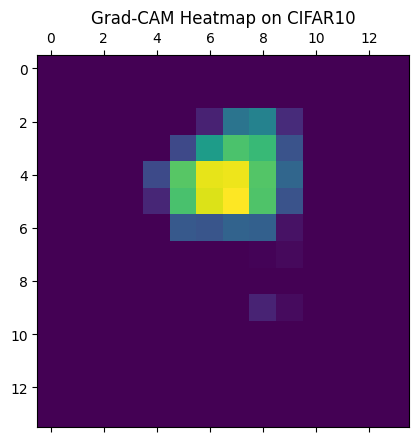

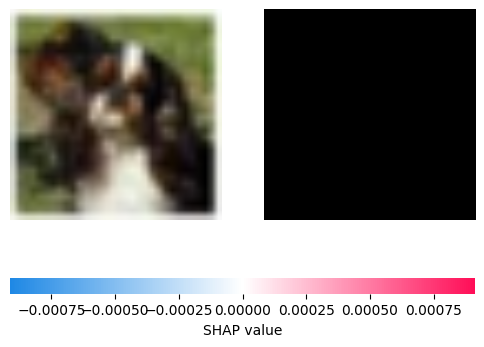

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/eli5/formatters/html.py:237: RuntimeWarning: invalid value encountered in scalar divide
  rel_weight = (abs(weight) / weight_range) ** 0.7


Weight,Feature
0 ± 0.0000,cat__Release Clause_€95.3M
0 ± 0.0000,cat__Release Clause_€94K
0 ± 0.0000,num__StandingTackle
0 ± 0.0000,num__Marking
0 ± 0.0000,num__Composure
0 ± 0.0000,num__Penalties
0 ± 0.0000,num__Vision
0 ± 0.0000,num__Positioning
0 ± 0.0000,num__Interceptions
0 ± 0.0000,num__Aggression


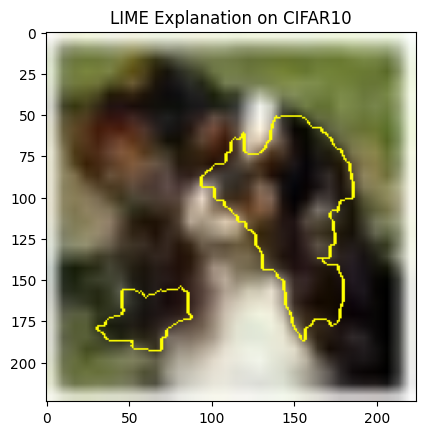

In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import cv2
from tensorflow.keras.datasets import cifar10
(x_train, y_train_img), (x_test, y_test_img) = cifar10.load_data()
classes = [3, 5]
mask_train = np.isin(y_train_img, classes).flatten()
mask_test = np.isin(y_test_img, classes).flatten()
X_tr_full, Y_tr_full = x_train[mask_train], y_train_img[mask_train]
X_te_full, Y_te_full = x_test[mask_test], y_test_img[mask_test]
def limit_per_class(X, Y, max_per=500):
    X_out, Y_out = [], []
    for cls in [0,1]:
        cls_mask = (Y.flatten() == classes[cls])
        selected = np.where(cls_mask)[0][:max_per]
        X_out.append(X[selected])
        Y_out.append(np.full(len(selected), cls))
    return np.vstack(X_out), np.concatenate(Y_out)
X_tr, Y_tr = limit_per_class(X_tr_full, Y_tr_full)
X_te, Y_te = limit_per_class(X_te_full, Y_te_full)
ixs = np.random.RandomState(42).permutation(len(Y_tr))
X_tr, Y_tr = X_tr[ixs], Y_tr[ixs]

import tensorflow as tf

size = (224, 224)
X_tr_resized = tf.image.resize(X_tr, size).numpy() / 255.0
X_te_resized = tf.image.resize(X_te, size).numpy() / 255.0
def resize_images(imgs):
    resized = np.zeros((imgs.shape[0], 224, 224, 3), dtype='float32')
    for i in range(imgs.shape[0]):
        resized[i] = cv2.resize(imgs[i], (224,224))
    return resized

X_tr_resized = resize_images(X_tr) / 255.0
X_te_resized = resize_images(X_te) / 255.0

input_tensor = Input(shape=(224,224,3))
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)
for layer in base_model.layers:
    layer.trainable = False
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
out = Dense(1, activation='sigmoid')(x)
cnn_model = Model(inputs=base_model.input, outputs=out)
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from sklearn.model_selection import train_test_split
X_trn, X_val, y_trn, y_val = train_test_split(X_tr_resized, Y_tr, test_size=0.2, random_state=42, stratify=Y_tr)

cnn_model.fit(X_trn, y_trn, validation_data=(X_val, y_val), epochs=5, callbacks=[EarlyStopping(patience=3)])

y_val_pred_prob = cnn_model.predict(X_val)
y_val_pred = (y_val_pred_prob > 0.5).astype(int).flatten()
mis_idxs = np.where(y_val_pred != y_val)[0]
if len(mis_idxs)==0:
    raise ValueError("No misclassified examples found in validation set.")
idx = mis_idxs[0]
mis_image = X_val[idx:idx+1]
true_lbl, pred_lbl = y_val[idx], y_val_pred[idx]
print(f"Misclassified sample idx={idx}: true={true_lbl}, pred={pred_lbl}")


def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    import tensorflow as tf
    from tensorflow.keras.models import Model
    grad_model = Model(inputs=model.inputs,
                       outputs=[model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

heatmap = make_gradcam_heatmap(mis_image, cnn_model, 'block5_conv3')
plt.matshow(heatmap); plt.title('Grad-CAM Heatmap on CIFAR10')

explainer = shap.GradientExplainer(cnn_model, X_val[:50])
shap_vals = explainer.shap_values(mis_image)
shap.image_plot(shap_vals, mis_image)

lime_exp = lime_image.LimeImageExplainer()
explanation = lime_exp.explain_instance(mis_image[0], cnn_model.predict, top_labels=1, hide_color=0, num_samples=1000)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask)); plt.title('LIME Explanation on CIFAR10')

import numpy as np
idx_sample = np.random.RandomState(42).choice(len(y_test), size=5, replace=False)
X_sample = X_test_dense[idx_sample]
y_sample = y_test.iloc[idx_sample]

perm = PermutationImportance(
    rf_w, random_state=42, n_iter=2
).fit(X_sample, y_sample)

import eli5
eli5.show_weights(perm, feature_names=feature_names, top=20)

### Why this part is done and what is learned:


### **7.1 Load CIFAR-10**
- CIFAR-10 is a dataset with 10 image classes of 32×32 pixels. A binary classification subset (classes 3 and 5) is selected for simplicity.
- Only a limited number of samples (500 per class) are used to reduce memory usage.
- The labels are converted to binary class indices: `class 3 → 0` and `class 5 → 1`.

**What is gained**: A lightweight binary dataset from CIFAR-10, suitable for binary classification and explainability techniques.


### **7.2 Resize Images**
- Images are resized to 224×224 using both TensorFlow and OpenCV (`cv2`) to make them compatible with pre-trained models like VGG16.

**Why**: VGG16 expects input shape `(224,224,3)`, not 32×32.

**What is gained**: Compatibility with VGG16 model architecture, enabling transfer learning from pre-trained ImageNet weights.


### **7.3 Train a VGG16-based Binary Classifier**
- A transfer learning model is built using VGG16 (convolutional base is frozen).
- A small dense head with 128 units and sigmoid output is added for binary classification.
- Training/validation split is done manually, and early stopping is used to avoid overfitting.

**What is gained**: A decent image classifier trained with limited resources using transfer learning. This also sets the stage for analyzing model predictions using explainability tools.


### **7.4 Identify a Misclassified Image**
- The trained model is used to predict on validation data.
- A misclassified example is identified to understand why the model made a wrong prediction.

**Why**: Explainability methods are most insightful when applied to incorrect predictions.

**What is gained**: A target sample for visual explanation methods like Grad-CAM, SHAP, and LIME.


### **7.5 Grad-CAM Helper Function**
- A custom Grad-CAM function is implemented to visualize where the CNN is "looking" in the image.
- This is done by computing gradients with respect to the last convolutional layer's outputs.

**Why**: Grad-CAM shows the spatial regions that contributed most to the prediction.

**What is gained**: Visual insight into model decision-making—highlighted regions correspond to "important" image features.


### **7.6 Explainability Methods**

#### a) Grad-CAM
- Grad-CAM is applied to the misclassified image.
- It produces a heatmap of important regions.

**What is gained**: Intuitive visual explanation—helps confirm whether the model focused on correct or irrelevant parts.

#### b) SHAP
- SHAP explains the model by attributing importance values to each pixel using gradient-based backpropagation.

**What is gained**: Pixel-level interpretability. Helps understand which pixels (or regions) pushed the model toward its decision.

#### c) LIME
- LIME perturbs image segments and evaluates the change in prediction to identify influential regions.

**What is gained**: Region-based explanations that help compare SHAP’s pixel-based outputs. It adds another layer of interpretability.

#### d) ELI5 (Permutation Importance)
- Applied on a tabular model (not the CNN) using random forest and permutation importance.
- Measures how shuffling each feature impacts model performance.

**Why**: Though not directly related to images, it shows how feature importance can be assessed in structured models.

**What is gained**: A comparison point for explainability in non-image models, demonstrating how interpretation differs across modalities.


---

#  Explainable AI Task

> Use the following methods to explain **why** the model misclassified an image:
>
> - Grad-CAM  
> - SHAP  
> - LIME  
> - ELI5  

---

## 1. Identify a Misclassified Example

Before you can explain *why* the model failed, you must first find an example where it made a mistake. On your validation set:

1. **Run your trained CNN** on each image.
2. **Compare** predicted labels vs. true labels.
3. **Select one** image (or a few) where prediction ≠ ground truth.

**Why?**  
Explaining a specific failure lets you pinpoint where and how the model’s focus or reasoning diverged from the correct decision.

---

## 2. Grad-CAM

**What it does**  
- Computes the gradient of the *predicted class score* with respect to the last convolutional layer.
- Aggregates gradients to produce a heatmap showing which regions influenced the prediction.

**Why use it**  
- Reveals *where* in the image the CNN is "looking" when making its decision.
- Highlights misdirected attention—e.g., background clutter or irrelevant regions.

**Key interpretation questions**  
- Does the heatmap concentrate on the actual object of interest?
- Or is the model fixated on irrelevant parts (e.g., logos, shadows)?

---

## 3. SHAP

**What it does**  
- Applies Shapley values (from game theory) to compute how each pixel/superpixel contributes to the final prediction.
- Considers all possible feature combinations for a principled importance score.

**Why use it**  
- Offers both *local* (this image) and *global* (across dataset) interpretability.
- Fairly quantifies the impact of each image region on the model's output.

**Key interpretation questions**  
- Which regions contributed positively or negatively to the *incorrect* class?
- Are there high-scoring irrelevant areas (e.g., background textures) suggesting overfitting?

---

## 4. LIME

**What it does**  
- Creates many perturbed versions of the image (e.g., hiding superpixels).
- Trains a simple local model (e.g., linear) to approximate the behavior near this specific instance.
- Highlights superpixels that most influenced the prediction.

**Why use it**  
- Provides a human-readable, intuitive explanation.
- Easier and faster to compute than SHAP, especially for larger images.

**Key interpretation questions**  
- Are the highlighted superpixels meaningful (e.g., parts of the target object)?
- Or are they irrelevant regions (e.g., borders, empty background)?

---

## 5. ELI5 (Permutation Importance)

**What it does**  
- Randomly permutes one feature at a time and measures the drop in model performance.
- For CNNs, apply it to top-layer activations or on a simpler tabular baseline model.

**Why use it**  
- Shows which high-level features (activations, filters, or tabular inputs) the model relied on most.
- Large accuracy drops on permutation indicate high feature importance.

**Key interpretation questions**  
- Which features were critical to the (incorrect) prediction?
- Is the model overly dependent on a small subset of features, suggesting fragility?

---

## 🔍 Bringing It All Together

To earn full credit and ensure clarity in your notebook:

1. **Display** each explanation method in its own cell, clearly labeled.
2. **Write** 2–4 analysis sentences per method:
   - What the output shows.
   - Why it reveals a failure mode (e.g., "Grad-CAM focused on a watermark, not the object").
3. **Compare methods** when relevant:
   - _Example_: "SHAP highlights both the object and the background, whereas LIME isolates just the head region."

**Goal:**  
By combining these four perspectives, you don’t just show *that* the model failed—you explain *how* and *why* it made the mistake. This insight can guide fixes such as data augmentation, architecture changes, or retraining.